In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
import re
import json
import requests
import subprocess
import glob
import os
import geopandas as gpd
from geopandas import GeoDataFrame
from pygeocoder import Geocoder

In [202]:
#!pip install folium

In [203]:
tow = pd.read_csv('/Users/elizabethclick/Desktop/DATA205/tow_clean.csv')
tow.drop(tow[tow['hh_income'] < 0].index, inplace = True)
tow.head()

,tow_date,tow_reason,storage_company,street,city,geo_location,longitude,latitude,location,block,NAME,hh_income,pop_total,pop_black,state,county,tract,block group
0,2020-12-11,REPO,Final Notice,21704 Stableview Dr,Gaithersburg,POINT (-77.175624 39.211873),-77.175624,39.211873,"(39.211873, -77.175624)",7001012,"Block Group 2, Census Tract 7001.01, Montgomer...",208929,1931,39,24,31,700101,7001012
1,2021-02-17,REPO,NaN,8212 Brink Rd,Gaithersburg,POINT (-77.167752 39.208712),-77.167752,39.208712,"(39.208712, -77.167752)",7001013,"Block Group 3, Census Tract 7001.01, Montgomer...",135208,800,10,24,31,700101,7001013
2,2021-02-10,REPO,Thomas,7321 Brink Rd,Gaithersburg,POINT (-77.148754 39.211605),-77.148754,39.211605,"(39.211605, -77.148754)",7001013,"Block Group 3, Census Tract 7001.01, Montgomer...",135208,800,10,24,31,700101,7001013
3,2020-02-15,REPO,Greenwood Recovery,21400 Laytonsville Rd,Gaithersburg,POINT (-77.141329 39.207148),-77.141329,39.207148,"(39.207148, -77.141329)",7001032,"Block Group 2, Census Tract 7001.03, Montgomer...",218173,1017,193,24,31,700103,7001032
4,2020-02-04,REPO,Greenwood Recovery,7571 Lindbergh Dr,Gaithersburg,POINT (-77.153158 39.166038),-77.153158,39.166038,"(39.166038, -77.153158)",7001033,"Block Group 3, Census Tract 7001.03, Montgomer...",172778,3112,345,24,31,700103,7001033


In [204]:
print(tow.shape)
print(tow[tow["storage_company"] == "Other"])

(19674, 18)
         tow_date tow_reason storage_company                  street  \
15     2020-08-02        PRV           Other  7501 Muncaster Mill Rd   
16     2020-08-12       FIRE           Other    17612 Phelps Hill Ln   
18     2020-12-20       REPO           Other  6314 Holland Meadow Ln   
21     2021-01-04       REPO           Other         7230 Antares Dr   
83     2020-12-03       REPO           Other        9214 Chadburn Pl   
...           ...        ...             ...                     ...   
19788  2021-01-23       REPO           Other      12122 Bentridge Pl   
19880  2020-08-13        NOP           Other       10524 Westlake Dr   
19884  2020-12-10        NOP           Other       10405 Westlake Dr   
19886  2021-02-01        PKG           Other     10400 Auto Park Ave   
19892  2021-01-23       REPO           Other       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
15           Gaithersburg  POINT (-77.1535

In [205]:
#Set constants by dropping duplicte rows in another dataframe 
pop_sort = tow.sort_values(["block"]).drop_duplicates(subset = 'pop_total', keep='first').reset_index() 
#calculate total population using blocks data
mc_population = sum(pop_sort["pop_total"]) 
mc_blackpop = sum(pop_sort["pop_black"]) 
print('Total MC population = ', mc_population) 
print('Total MC black population = ', mc_blackpop)
pop_sort["pop_white"] = pop_sort["pop_total"] - pop_sort["pop_black"]

#total city populations: reger back to this dataframe and sum the blocks pop_sort city_names = pd.Series(pop_sort['city'].unique()) city_names
city_melt = pd.melt(pop_sort, id_vars="city", value_vars=["pop_total", "pop_black", "pop_white"], var_name=None, value_name='value', col_level=None, ignore_index=True)
city_popvals = city_melt.groupby(["city","variable"]).agg(sum_col=pd.NamedAgg(column="value", aggfunc="sum")) 

city_popvals = city_popvals.reset_index()
print(city_popvals)
city_popvals = city_popvals.pivot(index='city', columns=["variable"])
#city_popvals = pd.DataFrame(city_popvals)
#city_popvalsdf = pd.DataFrame(reshaped_city_popvals)
#city_popvalsdf = city_popvalsdf.columns.droplevel(0)
city_names = pd.Series(city_popvals.index)
city_names



Total MC population =  800033
Total MC black population =  171238
             city   variable  sum_col
0        Bethesda  pop_black     2503
1        Bethesda  pop_total    40164
2        Bethesda  pop_white    37661
3           Boyds  pop_black      754
4           Boyds  pop_total     5762
..            ...        ...      ...
58  Silver Spring  pop_total   258334
59  Silver Spring  pop_white   178231
60    Takoma Park  pop_black     3628
61    Takoma Park  pop_total    11270
62    Takoma Park  pop_white     7642

[63 rows x 3 columns]


0               Bethesda
1                  Boyds
2            Brookeville
3           Burtonsville
4             Cabin John
5            Chevy Chase
6             Clarksburg
7               Damascus
8                Derwood
9           Gaithersburg
10          Garrett Park
11            Germantown
12            Kensington
13    Montgomery Village
14                 Olney
15           Poolesville
16               Potomac
17             Rockville
18          Sandy Spring
19         Silver Spring
20           Takoma Park
Name: city, dtype: object

In [206]:
test = np.array(city_popvals)
df_test = pd.DataFrame(test)
df_test
df_test = df_test.rename(columns = {0 : "pop_black",
                            1 : "pop_total",
                            2 : "pop_white"})
df_test["city"] = ['Bethesda', 'Boyds', 'Brookeville', 'Burtonsville', 'Cabin John',
       'Chevy Chase', 'Clarksburg', 'Damascus', 'Derwood', 'Gaithersburg',
       'Garrett Park', 'Germantown', 'Kensington', 'Montgomery Village',
       'Olney', 'Poolesville', 'Potomac', 'Rockville', 'Sandy Spring', 'Silver Spring',
       'Takoma Park']
df_test

,pop_black,pop_total,pop_white,city
0,2503,40164,37661,Bethesda
1,754,5762,5008,Boyds
2,162,3004,2842,Brookeville
3,7323,14733,7410,Burtonsville
4,142,2121,1979,Cabin John
5,655,11725,11070,Chevy Chase
6,4508,25340,20832,Clarksburg
7,1247,11548,10301,Damascus
8,1059,10064,9005,Derwood
9,21566,125369,103803,Gaithersburg


In [207]:
## WHAT AREAS EXPERIENCE THE MOST TOWING
#subset cities with over 200 towings for the year
tow_city=tow['city'].value_counts()#[tow['city'].value_counts()> 200]
city_count = tow["city"].value_counts()
city_freq = tow["city"].value_counts(normalize = True)
#make a new dataframe with values from counts and city population values above
city_df = pd.DataFrame(tow_city, tow_city.index)
city_df = city_df.rename(columns={'city': 'tow_count'})

city_df = city_df.reset_index()
city_df = city_df.rename(columns={'index': 'city'})
print(city_df)
print(df_test)
city_uniform = city_df.merge(right = df_test, how='inner', on="city", left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

city_uniform["tow_rate"] = city_uniform["tow_count"] / city_uniform["pop_total"]
city_uniform

                  city  tow_count
0        Silver Spring       8419
1         Gaithersburg       3221
2           Germantown       2464
3            Rockville       1889
4   Montgomery Village       1732
5             Bethesda        558
6          Takoma Park        330
7         Burtonsville        320
8             Damascus        163
9              Derwood        159
10               Olney        143
11         Chevy Chase        124
12          Kensington         61
13          Clarksburg         44
14             Potomac         30
15               Boyds          6
16         Brookeville          5
17         Poolesville          3
18          Cabin John          1
19        Sandy Spring          1
20        Garrett Park          1
    pop_black  pop_total  pop_white                city
0        2503      40164      37661            Bethesda
1         754       5762       5008               Boyds
2         162       3004       2842         Brookeville
3        7323      14733    

,city,tow_count,pop_black,pop_total,pop_white,tow_rate
0,Silver Spring,8419,80103,258334,178231,0.032590
1,Gaithersburg,3221,21566,125369,103803,0.025692
2,Germantown,2464,21374,82481,61107,0.029874
3,Rockville,1889,13410,110425,97015,0.017107
4,Montgomery Village,1732,6898,32492,25594,0.053305
5,Bethesda,558,2503,40164,37661,0.013893
6,Takoma Park,330,3628,11270,7642,0.029281
7,Burtonsville,320,7323,14733,7410,0.021720
8,Damascus,163,1247,11548,10301,0.014115
9,Derwood,159,1059,10064,9005,0.015799


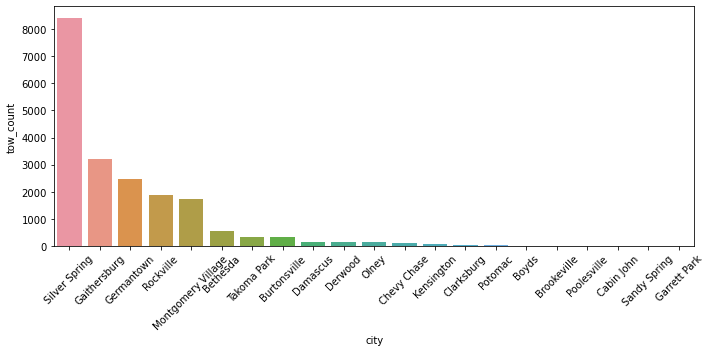

In [208]:
#visualization of towing by city: Chose top 8 to examine further
sns.barplot(x="city", y="tow_count", data = city_uniform)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

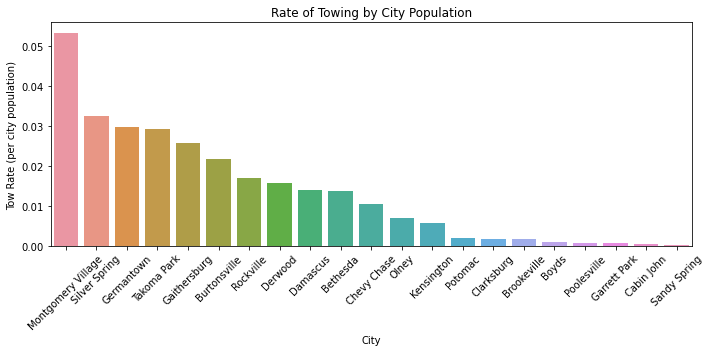

In [209]:
#visualization of towing by city: Chose top 8 to examine further
city_uniform = city_uniform.sort_values(by = ["tow_rate"], ascending=False)
sns.barplot(x="city", y="tow_rate", data = city_uniform)
plt.title("Rate of Towing by City Population")
plt.xlabel("City")
plt.ylabel("Tow Rate (per city population)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [210]:
##WHAT IS THE MOST COMMON REASON FOR TOWING?
tow_code=tow['tow_reason'].value_counts(normalize = True)[tow['tow_reason'].value_counts(normalize = True)> 0.0099]
reason_count = tow["tow_reason"].value_counts()
reason_freq = tow["tow_reason"].value_counts(normalize = True)
print(reason_freq)
tow_code


NOP                   0.508953
PKG                   0.204955
PRV                   0.087751
REPO                  0.072083
FIRE                  0.056873
                        ...   
HENRYS                0.000051
VISITOR VIOLATION     0.000051
NO HANDICAP PERMIT    0.000051
RESERVED SPOT         0.000051
MULTIPLE SPACES       0.000051
Name: tow_reason, Length: 215, dtype: float64


NOP     0.508953
PKG     0.204955
PRV     0.087751
REPO    0.072083
FIRE    0.056873
EXP     0.026961
Name: tow_reason, dtype: float64

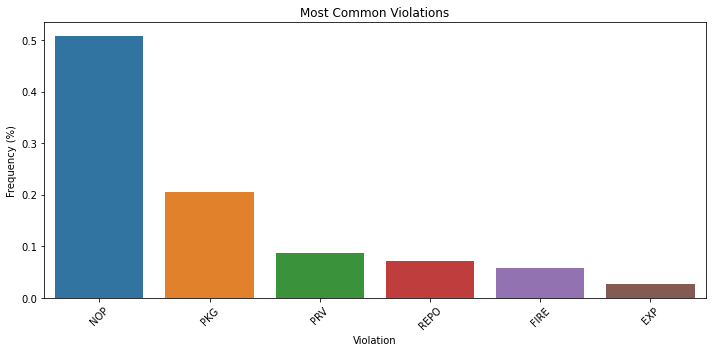

In [211]:
#visualization of towing by reason
sns.barplot(x=tow_code.index, y=tow_code)
plt.title("Most Common Violations")
plt.xlabel("Violation")
plt.ylabel("Frequency (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [212]:
##WHICH COMPANIES ARE TOWING AND ARE THERE DISCREPANCIES?
tow_company=tow['storage_company'].value_counts(normalize = True)[tow['storage_company'].value_counts(normalize = True)> 0.01]
company_count = tow["storage_company"].value_counts()
company_freq = tow["storage_company"].value_counts(normalize = True)
print(company_freq)
tow_company

Henrys                        0.317288
Authorized                    0.161947
Prestige                      0.087446
Speedy                        0.053313
Other                         0.050460
                                ...   
Authorized`                   0.000053
Drivw=E                       0.000053
Cpi Towing                    0.000053
Spedy                         0.000053
American Credit Acceptance    0.000053
Name: storage_company, Length: 264, dtype: float64


Henrys         0.317288
Authorized     0.161947
Prestige       0.087446
Speedy         0.053313
Other          0.050460
Drive          0.044489
Diversified    0.026260
Auburn         0.023090
Big            0.021241
Led            0.012522
Custom         0.012364
Name: storage_company, dtype: float64

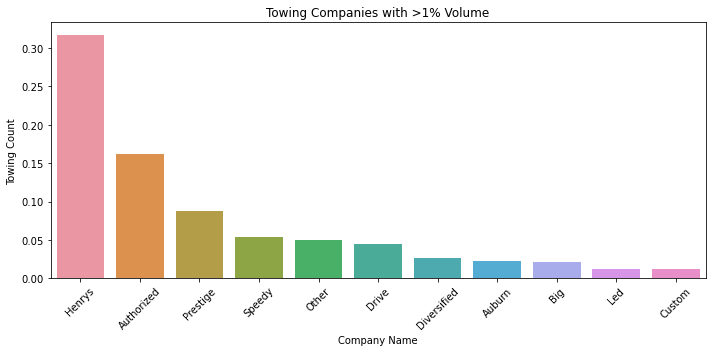

In [213]:
#Visualization of towing by company
sns.barplot(x=tow_company.index, y=tow_company)
plt.title("Towing Companies with >1% Volume")
plt.xlabel("Company Name")
plt.ylabel("Towing Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [214]:
#838 companies still listed as Tcl could not be identified
print(tow[tow["storage_company"] == "Other"])

         tow_date tow_reason storage_company                  street  \
15     2020-08-02        PRV           Other  7501 Muncaster Mill Rd   
16     2020-08-12       FIRE           Other    17612 Phelps Hill Ln   
18     2020-12-20       REPO           Other  6314 Holland Meadow Ln   
21     2021-01-04       REPO           Other         7230 Antares Dr   
83     2020-12-03       REPO           Other        9214 Chadburn Pl   
...           ...        ...             ...                     ...   
19788  2021-01-23       REPO           Other      12122 Bentridge Pl   
19880  2020-08-13        NOP           Other       10524 Westlake Dr   
19884  2020-12-10        NOP           Other       10405 Westlake Dr   
19886  2021-02-01        PKG           Other     10400 Auto Park Ave   
19892  2021-01-23       REPO           Other       10518 Westlake Dr   

                     city                  geo_location  longitude   latitude  \
15           Gaithersburg  POINT (-77.153568 39.153681

In [215]:
#group company for each city - results in multi-index dataframe
grp1 =  tow.groupby(["storage_company", "city"]).agg(count_col=pd.NamedAgg(column="storage_company", aggfunc="count"))     
print(type(grp1))
grp1

<class 'pandas.core.frame.DataFrame'>


count_col
storage_company                 city                         
14505 Lee Hwy                   Silver Spring               1
301-562-4020                    Gaithersburg                1
3018779285                      Silver Spring               1
7908 Bellefonte Ln, Clinton, Md Gaithersburg                1
A &M                            Germantown                  1
...                                                       ...
Westlake                        Germantown                  9
                                Montgomery Village          4
                                Olney                       1
                                Rockville                   5
                                Silver Spring              21

[739 rows x 1 columns]

In [216]:
#flatten above df from multi-index to regular index
grp1 = grp1.reset_index()
grp1

,storage_company,city,count_col
0,14505 Lee Hwy,Silver Spring,1
1,301-562-4020,Gaithersburg,1
2,3018779285,Silver Spring,1
3,"7908 Bellefonte Ln, Clinton, Md",Gaithersburg,1
4,A &M,Germantown,1
...,...,...,...
734,Westlake,Germantown,9
735,Westlake,Montgomery Village,4
736,Westlake,Olney,1
737,Westlake,Rockville,5


In [217]:
#top 8 cities
city_list8 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville',
        'Montgomery Village', 'Bethesda', 'Burtonsville', 'Takoma Park']
city_list5 = ['Silver Spring', 'Gaithersburg', 'Germantown', 'Rockville','Montgomery Village']

In [218]:
companies = ["Henrys", "Prestige", "Authorized", "Speedy", "Tcl"]
df5 = grp1.loc[grp1['storage_company'].isin(companies)]
#df5["total"] = int(count_col)
df5 = df5.loc[df5['city'].isin(city_list8)]
df5

,storage_company,city,count_col
99,Authorized,Bethesda,14
100,Authorized,Burtonsville,13
102,Authorized,Gaithersburg,467
103,Authorized,Germantown,408
104,Authorized,Montgomery Village,276
105,Authorized,Rockville,383
106,Authorized,Silver Spring,1464
107,Authorized,Takoma Park,19
372,Henrys,Bethesda,195
374,Henrys,Burtonsville,50


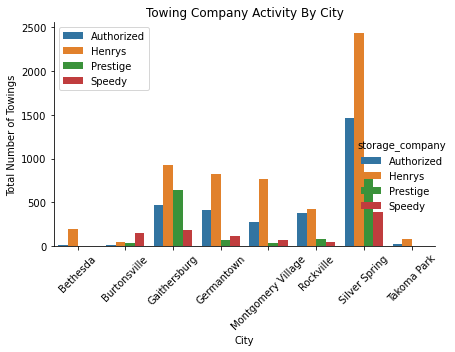

In [219]:
#Visualization of towing by company
sns.catplot(x="city", y="count_col", hue="storage_company", kind="bar", data=df5)
plt.xticks(rotation=45)
plt.title("Towing Company Activity By City")
plt.xlabel("City")
plt.ylabel("Total Number of Towings")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [220]:
#COMPARISON OF HOUSEHOLD INCOME BETWEEN CITIES; BOXPLOT FOR TOP 8.

In [221]:
#Create dataframe with demographics and geo only
tow_demo = tow.drop(columns = ["tow_date", "tow_reason", "storage_company", "street", "longitude", "latitude", "location", "tract"])
tow_demo["pop_white"] = tow_demo["pop_total"] - tow_demo["pop_black"]
print(tow_demo.head())
tow_demo.info()

           city                  geo_location    block  \
0  Gaithersburg  POINT (-77.175624 39.211873)  7001012   
1  Gaithersburg  POINT (-77.167752 39.208712)  7001013   
2  Gaithersburg  POINT (-77.148754 39.211605)  7001013   
3  Gaithersburg  POINT (-77.141329 39.207148)  7001032   
4  Gaithersburg  POINT (-77.153158 39.166038)  7001033   

                                                NAME  hh_income  pop_total  \
0  Block Group 2, Census Tract 7001.01, Montgomer...     208929       1931   
1  Block Group 3, Census Tract 7001.01, Montgomer...     135208        800   
2  Block Group 3, Census Tract 7001.01, Montgomer...     135208        800   
3  Block Group 2, Census Tract 7001.03, Montgomer...     218173       1017   
4  Block Group 3, Census Tract 7001.03, Montgomer...     172778       3112   

   pop_black  state  county  block group  pop_white  
0         39     24      31      7001012       1892  
1         10     24      31      7001013        790  
2         10     24 

In [222]:
#show each city demo with countys of towing by block in tow_demo
city_grp = tow_demo.groupby(["city", "hh_income", "pop_total", "pop_black", "pop_white"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
print(city_grp)
city_grp = city_grp.reset_index() #flatten level
#put demo count by city in dataframe "city_df"
citygrp_df = pd.DataFrame(city_grp)
citygrp_df
citygrp_df["tow_rate"] = citygrp_df["count_col"] / citygrp_df["pop_total"]
citygrp_df["black_rate"] = citygrp_df["pop_black"] / citygrp_df["pop_total"]
#we can see that towing decreases as hh_income increases
print(citygrp_df[citygrp_df["city"] == "Germantown"])

                                                     count_col
city        hh_income pop_total pop_black pop_white           
Bethesda    56677     1203      313       890               68
            59205     1032      200       832               67
            62000     892       121       771               35
            64934     1237      221       1016              11
            70132     1335      235       1100               1
...                                                        ...
Takoma Park 98333     1653      467       1186              21
            106875    2104      401       1703              19
            122500    967       46        921                4
            137330    1360      233       1127               5
            152875    1282      273       1009               6

[510 rows x 1 columns]
           city  hh_income  pop_total  pop_black  pop_white  count_col  \
158  Germantown      44784       1505        364       1141        145   
159  Germ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377 entries, 83 to 495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        377 non-null    object 
 1   hh_income   377 non-null    int64  
 2   pop_total   377 non-null    int64  
 3   pop_black   377 non-null    int64  
 4   pop_white   377 non-null    int64  
 5   count_col   377 non-null    int64  
 6   tow_rate    377 non-null    float64
 7   black_rate  377 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 26.5+ KB
None
              city  hh_income  pop_total  pop_black  pop_white  count_col  \
83    Gaithersburg      42212        621         68        553         35   
84    Gaithersburg      47743       1560        263       1297         69   
85    Gaithersburg      50977       1693        416       1277         56   
86    Gaithersburg      54861       1375        585        790          9   
87    Gaithersburg      55037   

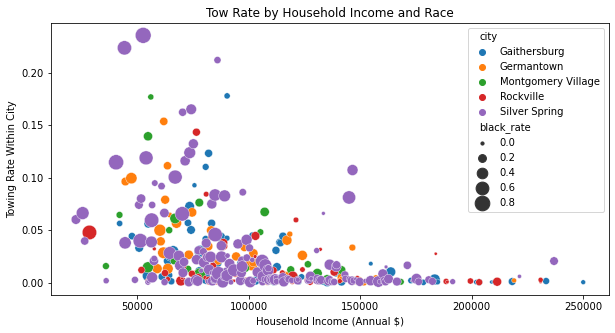

In [223]:
top5_demo = citygrp_df.loc[citygrp_df['city'].isin(city_list5)]
print(top5_demo.info())
print(top5_demo)

sns.scatterplot(x='hh_income', y='tow_rate', hue = "city", size = "black_rate", data=top5_demo, sizes=(10, 250))
#sns.scatterplot(data=data, x="gdpPercap", y="lifeExp", size="pop", legend=False, sizes=(20, 2000))
plt.title("Tow Rate by Household Income and Race")
plt.xlabel("Household Income (Annual $)")
plt.ylabel("Towing Rate Within City")
plt.show()
#WE CAN CLEARLY SEE THAT THE LOWER INCOME TOWINGS (RATE = COUNT/CITY POPULATION) APPEAR EXCESSIVE FOR TOP 5 TOWED CITIES
#WE CAN ALSO SEE THE LOWEST INCOME RATES EXPERIENCING EXCESSIVE TOWING ARE AS HIGH AS 80% BLACK POPULATIONS; 
#THIS IS WHAT SYSTEMIC RACISM LOOKS LIKE

In [224]:
#Investigate < 60000 hh_income: NEED MORE
print(top5_demo.loc[top5_demo["hh_income"]<60000])
 



                   city  hh_income  pop_total  pop_black  pop_white  \
83         Gaithersburg      42212        621         68        553   
84         Gaithersburg      47743       1560        263       1297   
85         Gaithersburg      50977       1693        416       1277   
86         Gaithersburg      54861       1375        585        790   
87         Gaithersburg      55037       3568        845       2723   
158          Germantown      44784       1505        364       1141   
159          Germantown      47472       1266        579        687   
160          Germantown      59033       1880        640       1240   
213  Montgomery Village      36071       2545        364       2181   
214  Montgomery Village      42159       1225        171       1054   
215  Montgomery Village      54861       1375        585        790   
216  Montgomery Village      54931       2201        626       1575   
217  Montgomery Village      56188       1921        197       1724   
258   

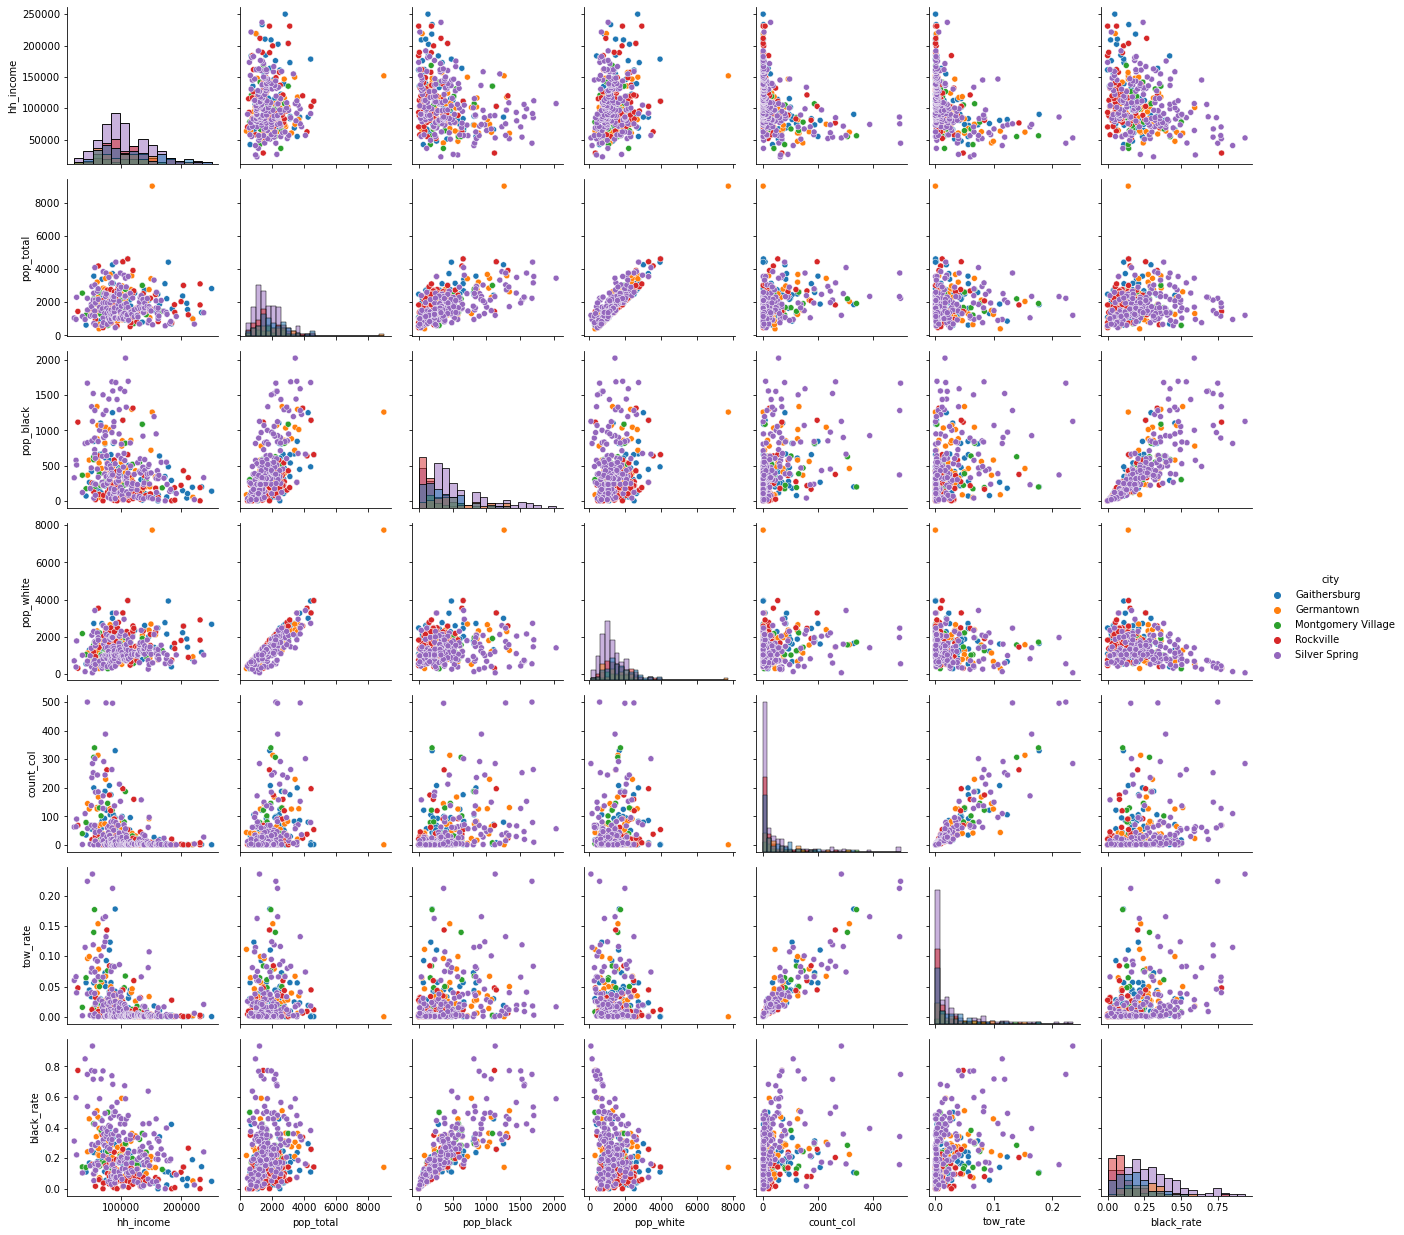

In [225]:
g = sns.PairGrid(top5_demo, hue="city")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [226]:
#Independent Dataframes by City
btc = citygrp_df[citygrp_df['city']=="Bethesda"]
btb = citygrp_df[citygrp_df['city']=="Burtonsville"]
gbc = citygrp_df[citygrp_df['city']=="Gaithersburg"]
gtc = citygrp_df[citygrp_df['city']=="Germantown"]
mvc = citygrp_df[citygrp_df['city']=="Montgomery Village"]
rvc = citygrp_df[citygrp_df['city']=="Rockville"]
ssc = citygrp_df[citygrp_df['city']=="Silver Spring"]
tpc = citygrp_df[citygrp_df["city"]=="Takoma Park"]
print(sum(ssc["tow_rate"]))
gbc


4.371447531312931


,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
83,Gaithersburg,42212,621,68,553,35,0.056361,0.109501
84,Gaithersburg,47743,1560,263,1297,69,0.044231,0.168590
85,Gaithersburg,50977,1693,416,1277,56,0.033077,0.245718
86,Gaithersburg,54861,1375,585,790,9,0.006545,0.425455
87,Gaithersburg,55037,3568,845,2723,200,0.056054,0.236827
...,...,...,...,...,...,...,...,...
152,Gaithersburg,208929,1931,39,1892,1,0.000518,0.020197
153,Gaithersburg,210179,1557,103,1454,1,0.000642,0.066153
154,Gaithersburg,218173,1017,193,824,1,0.000983,0.189774
155,Gaithersburg,233362,1376,198,1178,2,0.001453,0.143895


In [227]:
#HEATMAPS OF TOP 5 CITIES SHOW PROBLEM AREAS

gtc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
158,Germantown,44784,1505,364,1141,145,0.096346,0.241860
159,Germantown,47472,1266,579,687,126,0.099526,0.457346
160,Germantown,59033,1880,640,1240,25,0.013298,0.340426
161,Germantown,60268,2624,1339,1285,131,0.049924,0.510290
162,Germantown,60625,3207,882,2325,126,0.039289,0.275023
163,Germantown,61838,2285,1072,1213,65,0.028446,0.469147
164,Germantown,62000,2043,459,1584,314,0.153696,0.224670
165,Germantown,62614,2127,559,1568,168,0.078984,0.262811
166,Germantown,63659,395,86,309,44,0.111392,0.217722
167,Germantown,63819,1361,538,823,18,0.013226,0.395298


In [228]:
gbc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
83,Gaithersburg,42212,621,68,553,35,0.056361,0.109501
84,Gaithersburg,47743,1560,263,1297,69,0.044231,0.168590
85,Gaithersburg,50977,1693,416,1277,56,0.033077,0.245718
86,Gaithersburg,54861,1375,585,790,9,0.006545,0.425455
87,Gaithersburg,55037,3568,845,2723,200,0.056054,0.236827
88,Gaithersburg,61154,887,158,729,5,0.005637,0.178129
89,Gaithersburg,63824,1551,392,1159,32,0.020632,0.252740
90,Gaithersburg,64429,2604,385,2219,18,0.006912,0.147849
91,Gaithersburg,64805,2685,661,2024,66,0.024581,0.246182
92,Gaithersburg,65368,869,132,737,1,0.001151,0.151899


In [229]:
mvc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
213,Montgomery Village,36071,2545,364,2181,40,0.015717,0.143026
214,Montgomery Village,42159,1225,171,1054,79,0.064490,0.139592
215,Montgomery Village,54861,1375,585,790,20,0.014545,0.425455
216,Montgomery Village,54931,2201,626,1575,307,0.139482,0.284416
217,Montgomery Village,56188,1921,197,1724,340,0.176991,0.102551
218,Montgomery Village,64429,2604,385,2219,130,0.049923,0.147849
219,Montgomery Village,66591,1266,215,1051,26,0.020537,0.169826
220,Montgomery Village,67071,1668,637,1031,102,0.061151,0.381894
221,Montgomery Village,72841,1634,277,1357,21,0.012852,0.169523
222,Montgomery Village,77917,1915,467,1448,146,0.076240,0.243864


In [230]:
rvc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
258,Rockville,28681,1444,1118,326,69,0.047784,0.774238
259,Rockville,52000,1590,255,1335,19,0.011950,0.160377
260,Rockville,54891,1311,127,1184,2,0.001526,0.096873
261,Rockville,57750,964,16,948,31,0.032158,0.016598
262,Rockville,62548,4180,638,3542,38,0.009091,0.152632
263,Rockville,63824,1531,91,1440,5,0.003266,0.059438
264,Rockville,69659,639,224,415,1,0.001565,0.350548
265,Rockville,70250,464,0,464,2,0.004310,0.000000
266,Rockville,71063,2123,79,2044,32,0.015073,0.037211
267,Rockville,74596,2625,394,2231,22,0.008381,0.150095


In [231]:
ssc.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})



,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
332,Silver Spring,22628,1048,327,721,63,0.060115,0.312023
333,Silver Spring,25636,966,576,390,64,0.066253,0.596273
334,Silver Spring,26563,2296,509,1787,91,0.039634,0.221690
335,Silver Spring,36172,1141,118,1023,2,0.001753,0.103418
336,Silver Spring,40625,959,815,144,110,0.114703,0.849844
337,Silver Spring,44375,2234,1672,562,500,0.223814,0.748433
338,Silver Spring,44662,1532,826,706,58,0.037859,0.539164
339,Silver Spring,49070,1165,175,990,3,0.002575,0.150215
340,Silver Spring,50843,1863,467,1396,138,0.074074,0.250671
341,Silver Spring,51477,1730,1337,393,69,0.039884,0.772832


In [232]:
#TEST IF INCOME IN PAIRED CITIES HAVE THE SAME DISTRIBUTION OR ARE DIFFERENT
#H_0: THEY HAVE THE SAME DISTRIBUTIONS
#H_alpha: THEY HAVE DIFFERENT DISTRIBUTIONS
#alpha = 0.95

#FOR GERMANTOWN: Montgomery Village, alpha > 0.05; cannot reject the null 
#FOR GERMANTOWN: Gaithersburg, Rockville, Silver Spring, alpha < 0.05; reject the null

In [233]:
#Mann Whitney U Test:  GERMANTOWN
import scipy.stats
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(gbc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1211.0, pvalue=0.010228066652558307)

In [234]:
scipy.stats.mannwhitneyu(mvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=435.0, pvalue=0.2547179195727841)

In [235]:
scipy.stats.mannwhitneyu(rvc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=826.0, pvalue=5.770203694193223e-06)

In [236]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gtc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=2700.0, pvalue=0.005235736244517493)

In [237]:
#Mann Whitney U Test ; GAITHERSBURG 

#For Gaithersburg: Rockville, Silver Spring, alpha > 0.05; cannot reject the null 
#For Gaithersburg: Montgomery Village, Germantown; reject the null
scipy.stats.mannwhitneyu(mvc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=522.0, pvalue=0.005525737109465313)

In [238]:
scipy.stats.mannwhitneyu(rvc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=2320.5, pvalue=0.07048359025848593)

In [239]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], gbc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=5807.5, pvalue=0.2984568999776458)

In [240]:
#Mann Whitney U Test ; MONTGOMERY VILLAGE
#For Montgomery Village:  Germantown, alpha > 0.05; cannot reject the null 
#For Montgomery Village: Rockville, Silver Spring, Gaithersburg.    reject the null
scipy.stats.mannwhitneyu(rvc["tow_rate"], mvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=335.0, pvalue=1.8582765768029133e-05)

In [241]:
scipy.stats.mannwhitneyu(ssc["tow_rate"], mvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=1203.0, pvalue=0.0056625887737787395)

In [242]:
#Mann Whitney U Test ; ROCKVILLE
#For Rockville: Gaithersburg    alpha > 0.05; cannot reject the null 
#For Rockville: Montgomery Village, Silver Spring, Germantown;    reject the null
scipy.stats.mannwhitneyu(ssc["tow_rate"], rvc["tow_rate"], use_continuity = True, alternative=None)

MannwhitneyuResult(statistic=4697.0, pvalue=0.004093534880344547)

In [243]:
#Mann Whitney U Test ; SILVER SPRING
#For Silver Spring:  Gaithersburg ;    alpha > 0.05; cannot reject the null 
#For Silver Spring: Rockville, Montgomery Village, Germantown;    reject the null

In [244]:
#LOGISTIC REGRESSION

In [245]:
#GET p1, p2, p2, p4, p5 FOR THE TOP 5 TO COMPARE H_O: all equal, or H_alph: at least one is not equal; alpha = .05
#Compute probability of getting towed by household income within each city
top5_demo


,city,hh_income,pop_total,pop_black,pop_white,count_col,tow_rate,black_rate
83,Gaithersburg,42212,621,68,553,35,0.056361,0.109501
84,Gaithersburg,47743,1560,263,1297,69,0.044231,0.168590
85,Gaithersburg,50977,1693,416,1277,56,0.033077,0.245718
86,Gaithersburg,54861,1375,585,790,9,0.006545,0.425455
87,Gaithersburg,55037,3568,845,2723,200,0.056054,0.236827
...,...,...,...,...,...,...,...,...
491,Silver Spring,180750,726,134,592,2,0.002755,0.184573
492,Silver Spring,182396,835,162,673,1,0.001198,0.194012
493,Silver Spring,191488,1142,104,1038,1,0.000876,0.091068
494,Silver Spring,221429,680,17,663,4,0.005882,0.025000


In [246]:
block_grp =  tow_demo.groupby(["block", "city", "hh_income", "pop_total", "pop_black", "pop_white", "geo_location"]).agg(count_col=pd.NamedAgg(column="block", aggfunc="count"))
block_grp = block_grp.reset_index()
#put demo count by city in dataframe "block_df"
block_df = pd.DataFrame(block_grp)
block_df["tow_rate"] = block_df["count_col"] / block_df["pop_total"]
block_df

,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate
0,7001012,Gaithersburg,208929,1931,39,1892,POINT (-77.175624 39.211873),1,0.000518
1,7001013,Gaithersburg,135208,800,10,790,POINT (-77.148754 39.211605),1,0.001250
2,7001013,Gaithersburg,135208,800,10,790,POINT (-77.167752 39.208712),1,0.001250
3,7001032,Gaithersburg,218173,1017,193,824,POINT (-77.141329 39.207148),1,0.000983
4,7001033,Derwood,172778,3112,345,2767,POINT (-77.144138 39.147034),1,0.000321
...,...,...,...,...,...,...,...,...,...
5858,7060123,Bethesda,59205,1032,200,832,POINT (-77.149295 39.024606),14,0.013566
5859,7060123,Bethesda,59205,1032,200,832,POINT (-77.152166 39.026407),1,0.000969
5860,7060123,Bethesda,59205,1032,200,832,POINT (-77.152171 39.026405),13,0.012597
5861,7060123,Bethesda,59205,1032,200,832,POINT (-77.152785 39.026129),1,0.000969


In [247]:
#INVESTIGATE NEIGHBORHOODS WITH TOW RATES >=15%
#7015051 block is The Enclave Apartments at 11225 Oak Leaf Dr, Silver Spring
#7032141 block is Cinnamon Run at Peppertree Farms, 14120 Weeping Willow Dr, Aspen Hill?, not SS?
#7014222 block is Woodvale Apartments, 13831 Castle Blvd., Silver Spring, MD, Windsor Court and Tower Apartments,
#   13802 Castle Blvd

print("These blocks have tow rates >= 10%:  ")
print(block_df[block_df["tow_rate"] >= .10])
print(tow[tow["block"] == 7015051])    
print(tow[tow["block"] == 7032141])
print(tow[tow["block"] == 7014222])

These blocks have tow rates >= 10%:  
        block           city  hh_income  pop_total  pop_black  pop_white  \
2469  7008172   Gaithersburg      90385       1854        198       1656   
2560  7008182     Germantown      62000       2043        459       1584   
4040  7014222  Silver Spring      52768       1209       1129         80   
4161  7015051  Silver Spring      44375       2234       1672        562   
5132  7032133  Silver Spring      70446       1059        228        831   
5147  7032141  Silver Spring      86071       2338        368       1970   

                      geo_location  count_col  tow_rate  
2469  POINT (-77.201438 39.114884)        300  0.161812  
2560  POINT (-77.261484 39.179888)        273  0.133627  
4040  POINT (-76.942666 39.083117)        161  0.133168  
4161  POINT (-76.995468 39.040254)        435  0.194718  
5132  POINT (-77.079155 39.087717)        135  0.127479  
5147   POINT (-77.06692 39.088854)        448  0.191617  
         tow_date tow_r

In [248]:
btb = block_df[block_df['city']=="Bethesda"]
bvb = block_df[block_df['city']=="Burtonsville"]
gbb = block_df[block_df['city']=="Gaithersburg"]
gtb = block_df[block_df['city']=="Germantown"]
mvb = block_df[block_df['city']=="Montgomery Village"]
rvb = block_df[block_df['city']=="Rockville"]
ssb = block_df[block_df['city']=="Silver Spring"]
tpb = block_df[block_df['city']=="Takoma Park"]
print("Gaithersburg", gbb.describe())
print("Germantown", gtb.describe())
print("Montgomery_Village", mvb.describe())
print("Rockville", rvb.describe())
print("Silver Spring", ssb.describe())
btb



Gaithersburg               block      hh_income    pop_total    pop_black    pop_white  \
count  9.440000e+02     944.000000   944.000000   944.000000   944.000000   
mean   7.007267e+06   91342.598517  2264.361229   433.658898  1830.702331   
std    1.337022e+03   29565.173596   808.823778   260.621348   659.832918   
min    7.001012e+06   42212.000000   602.000000     0.000000   301.000000   
25%    7.007161e+06   73580.000000  1634.000000   235.000000  1310.000000   
50%    7.007201e+06   85952.000000  2231.000000   370.000000  1776.000000   
75%    7.008161e+06  103092.000000  2722.000000   608.000000  2284.000000   
max    7.013071e+06  250001.000000  4606.000000  1252.000000  3950.000000   

        count_col    tow_rate  
count  944.000000  944.000000  
mean     3.412076    0.001756  
std     13.455425    0.007465  
min      1.000000    0.000217  
25%      1.000000    0.000401  
50%      1.000000    0.000597  
75%      2.000000    0.001090  
max    300.000000    0.161812  
Germa

,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate
3302,7012053,Bethesda,124554,762,33,729,POINT (-77.126068 39.025879),20,0.026247
3303,7012053,Bethesda,124554,762,33,729,POINT (-77.126521 39.0286),1,0.001312
3304,7012053,Bethesda,124554,762,33,729,POINT (-77.127605 39.029056),2,0.002625
3305,7012053,Bethesda,124554,762,33,729,POINT (-77.127756 39.029152),3,0.003937
3306,7012053,Bethesda,124554,762,33,729,POINT (-77.128016 39.029317),38,0.049869
...,...,...,...,...,...,...,...,...,...
5858,7060123,Bethesda,59205,1032,200,832,POINT (-77.149295 39.024606),14,0.013566
5859,7060123,Bethesda,59205,1032,200,832,POINT (-77.152166 39.026407),1,0.000969
5860,7060123,Bethesda,59205,1032,200,832,POINT (-77.152171 39.026405),13,0.012597
5861,7060123,Bethesda,59205,1032,200,832,POINT (-77.152785 39.026129),1,0.000969


Text(0, 0.5, 'Household Income')

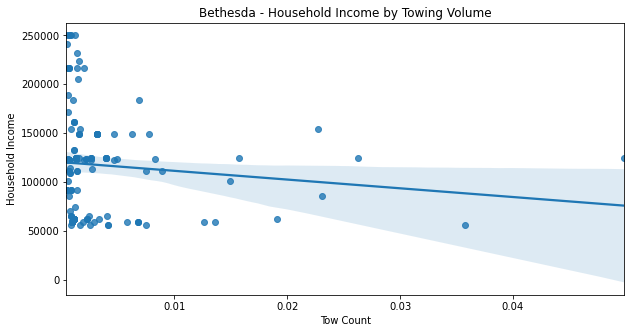

In [249]:
sns.regplot(x = "tow_rate", y = "hh_income", data = btb)
plt.title("Bethesda - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

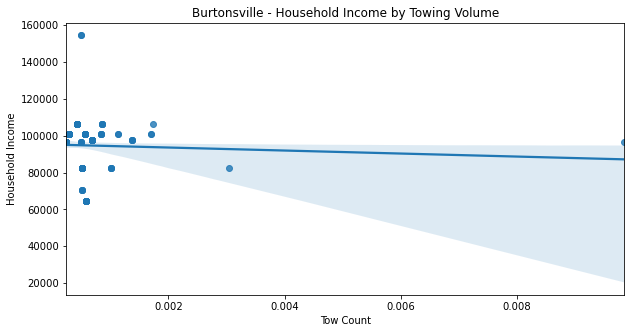

In [250]:
sns.regplot(x = "tow_rate", y = "hh_income", data = bvb)
plt.title("Burtonsville - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

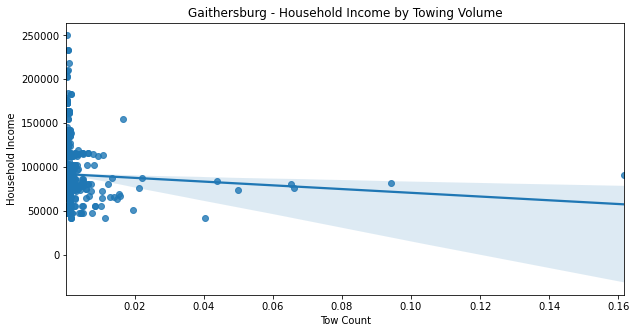

In [251]:
sns.regplot(x = "tow_rate", y = "hh_income", data = gbb)
plt.title("Gaithersburg - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

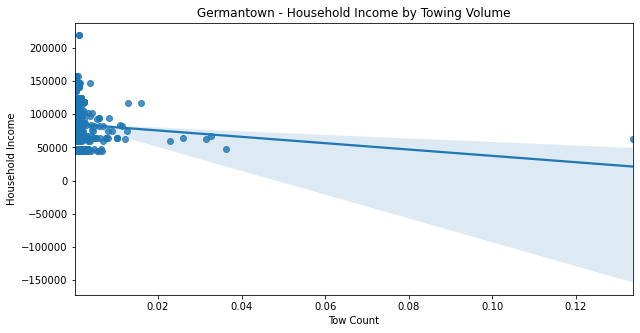

In [252]:
sns.regplot(x = "tow_rate", y = "hh_income", data = gtb)
plt.title("Germantown - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

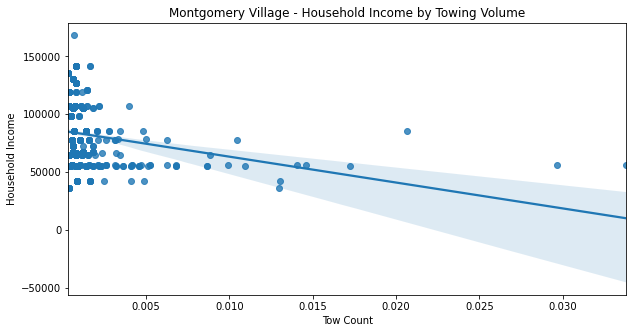

In [253]:
sns.regplot(x = "tow_rate", y = "hh_income", data = mvb)
plt.title("Montgomery Village - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

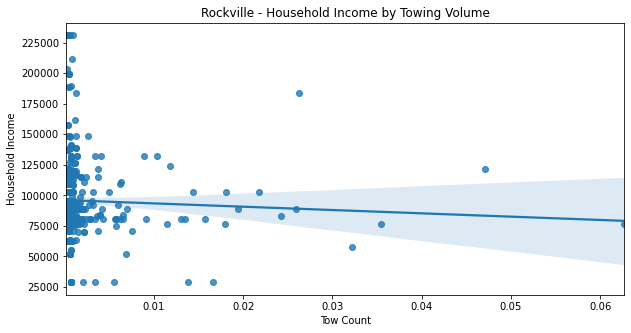

In [254]:
sns.regplot(x = "tow_rate", y = "hh_income", data = rvb)
plt.title("Rockville - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

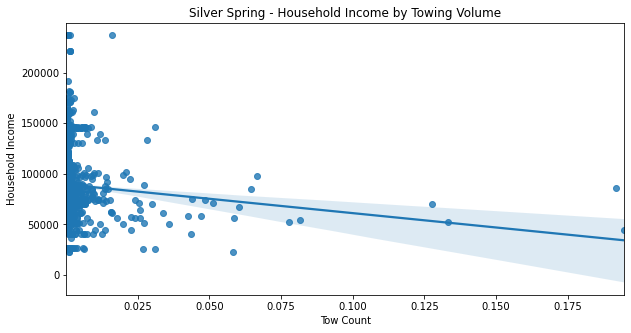

In [255]:
sns.regplot(x = "tow_rate", y = "hh_income", data = ssb)
plt.title("Silver Spring - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

Text(0, 0.5, 'Household Income')

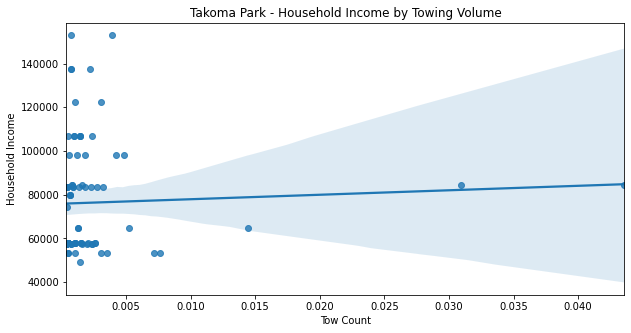

In [256]:
sns.regplot(x = "tow_rate", y = "hh_income", data = tpb)
plt.title("Takoma Park - Household Income by Towing Volume")
plt.xlabel("Tow Count")
plt.ylabel("Household Income")

In [257]:
#CREATE MAP

In [258]:
#Download Maryland County shapefiles as a geopanda called data0 (for now I have it saved on my computer)
url = "/Users/elizabethclick/Downloads/cb_2018_24_bg_500k/cb_2018_24_bg_500k.shp"
fol_plugin = gpd.read_file(url)
data0 = gpd.GeoDataFrame(fol_plugin)
print(data0.head())
#Refine all counties to Montgomery County only in data1 geopanda of geodata shapes
data1 = data0[data0['COUNTYFP'] == '031']
data1.info()
data1["block"] = data1["TRACTCE"] + data1["BLKGRPCE"]
data1["block"] = data1["block"].astype(int)

  STATEFP COUNTYFP TRACTCE BLKGRPCE               AFFGEOID         GEOID NAME  \
0      24      047  980000        1  1500000US240479800001  240479800001    1   
1      24      019  970900        2  1500000US240199709002  240199709002    2   
2      24      003  706302        3  1500000US240037063023  240037063023    3   
3      24      027  606606        1  1500000US240276066061  240276066061    1   
4      24      005  491201        1  1500000US240054912011  240054912011    1   

  LSAD      ALAND     AWATER  \
0   BG   36014136  196706380   
1   BG  264765218  196678699   
2   BG     500847     785990   
3   BG     709671          0   
4   BG    1126592          0   

                                            geometry  
0  POLYGON ((-75.37851 38.02457, -75.37755 38.026...  
1  MULTIPOLYGON (((-76.06544 38.12980, -76.06461 ...  
2  POLYGON ((-76.48555 38.97298, -76.48098 38.977...  
3  POLYGON ((-76.82290 39.21282, -76.82172 39.213...  
4  POLYGON ((-76.58843 39.40161, -76.58537 39

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [259]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[39.1483, -77.0668],
                     tiles="Cartodb Positron",
                     zoom_start=12,max_bounds=True)

marker_cluster = folium.plugins.MarkerCluster()
m

In [260]:
#DO I NEED TO DO THIS AGAIN? I ALREADY HAVE GEOCODES IN MONTGOMERY COUNTY CLEANED SET
#-nMAY BE BACKWARDS _ split out, reverse latitude and longitude for folium shapefile above?
#Pull desired census data from Census API
census_api_url='https://api.census.gov/data/2019/acs/acs5?key=5533410471151873cdf3e32fd6cacb45753daa2a&get=NAME,B29004_001E,B01003_001E,B02001_003E&for=block%20group:*&in=state:24&in=county:031&in=tract:*'
responseCensus = requests.get(census_api_url, headers={'Content-Type': 'application/json'})
textCensus=json.loads(responseCensus.content)
tractDF = pd.DataFrame(textCensus)
print('Shape of census tract file: ' + str(tractDF.shape))

tractDF.rename(columns = tractDF.iloc[0], inplace=True)
tractDF = tractDF.iloc[1:]
tractDF.rename(index=str,columns={'B29004_001E':'hh_income','B01003_001E':'pop_total',
                                  'B02001_003E':'pop_black','block group':'block',
                                  'tract':'tract'}, inplace=True)

Shape of census tract file: (615, 8)


In [261]:
block_new = block_df.copy()
block_new['block'] = block_df['block'].apply(str)
block_new['GEOID'] = ""

state_county = "24031"
for i in range(0,len(block_new)):
    block_new['GEOID'][i] = state_county + block_new['block'][i]   #tract is included in block code
    
block_new.head()

<ipython-input-261-e32ef4ceefac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_new['GEOID'][i] = state_county + block_new['block'][i]   #tract is included in block code


,block,city,hh_income,pop_total,pop_black,pop_white,geo_location,count_col,tow_rate,GEOID
0,7001012,Gaithersburg,208929,1931,39,1892,POINT (-77.175624 39.211873),1,0.000518,240317001012
1,7001013,Gaithersburg,135208,800,10,790,POINT (-77.148754 39.211605),1,0.001250,240317001013
2,7001013,Gaithersburg,135208,800,10,790,POINT (-77.167752 39.208712),1,0.001250,240317001013
3,7001032,Gaithersburg,218173,1017,193,824,POINT (-77.141329 39.207148),1,0.000983,240317001032
4,7001033,Derwood,172778,3112,345,2767,POINT (-77.144138 39.147034),1,0.000321,240317001033


In [262]:
block_gpd = gpd.GeoDataFrame(block_new)
print(type(block_gpd["geo_location"]))
data2 = pd.merge(data1, block_gpd, how='inside', left = ["GEOID", "block"], right = ["GEOID", "block"])

<class 'pandas.core.series.Series'>


TypeError: merge() got multiple values for argument 'left'